<a href="https://colab.research.google.com/github/Sonal12061/LangGraph_Implementations/blob/main/Hybrid_Agentic_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Pre-requistes**

### **Installing Libraries**

In [1]:
#!pip -q install --upgrade langgraph redis huggingface_hub chromadb langchain-huggingface

### **Running Redis locally**

In [2]:
!apt-get update && \
apt-get install -y redis-server && \
redis-server --daemonize yes

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

### **Running checks on redis, chromadb, huggingface**

In [3]:
import redis, chromadb
from google.colab import userdata

try:
    r = redis.Redis(host="localhost", port=6379, db=0)
    r.ping()
    print("✅ Redis: up & reachable")
except redis.exceptions.ConnectionError as e:
    sys.exit("❌ Redis failed to start ‑ check the logs")

print(f"✅ ChromaDB imported (version {chromadb.__version__})")
HF_TOKEN = userdata.get('HF_TOKEN')
print(f"✅ Got Hugging Face Token")

✅ Redis: up & reachable
✅ ChromaDB imported (version 1.0.15)
✅ Got Hugging Face Token


### **Analyzing with Mistral**

In [41]:
import os, re, json, random, textwrap
from huggingface_hub import InferenceClient

# Environment
DRY_RUN = False  # set True to stub API calls

# Initialize HuggingFace Inference client
if not DRY_RUN:
    client = InferenceClient(
        model="mistralai/Mistral-7B-Instruct-v0.2",
        token=HF_TOKEN,
        timeout=120,
    )
else:
    client = None


def analyze_with_mistral(text: str, *, content: str) -> dict:
    """
    Returns JSON with:
      {"primary_intent": "billing|tech_support|return|general_query",
       "secondary_intents": [<optional>]}
    Uses Mistral and a tailored prompt for intent classification.
    """
    if DRY_RUN:
        return {
            "primary_intent": random.choice(["billing", "tech_support", "return", "general_query"]),
            "secondary_intents": []
        }

    # System prompt for customer support intent classification
    system_msg = {
        "role": "system",
        "content": content
    }
    user_msg = {"role": "user", "content": text}

    # Call Mistral
    resp = client.chat_completion(
        messages=[system_msg, user_msg],
        temperature=0.2,
        max_tokens=200,
    )

    # Normalize response
    if isinstance(resp, dict) and "generated_text" in resp:
        raw = resp["generated_text"]
    elif getattr(resp, "choices", None):
        raw = resp.choices[0].message.content
    else:
        raise ValueError(f"Unexpected response from Mistral:\n{resp!r}")

    # Extract JSON
    match = re.search(r"\{.*\}", raw, re.S)
    if not match:
        #raise ValueError("❌ JSON not found in model output:\n" + raw[:500])
        return raw
    return json.loads(match.group())

### **CustomerSupportState**

In [31]:
from typing import TypedDict, List, Optional, Tuple

# ---- 1. Updated State ----
class CustomerSupportState(TypedDict, total=False):
    # raw input
    message_text: str
    # intent node outputs
    primary_intent: Optional[str]
    secondary_intents: List[str]
    intent_count: int
    intent_status: str          # NEW – only intent_node writes here
    # kb node outputs
    kb_results: str
    kb_count: int
    kb_status: str              # NEW – only kb_retriever_node writes here
    sentiment: str              # e.g. frustrated | polite | neutral
    urgency: str                # low | medium | high
    sent_count: int
    sent_status: str

    response_text: str
    comp_count: int
    comp_status: str

## **Intent Node**

In [6]:
import json

def intent_node(state: CustomerSupportState) -> CustomerSupportState:
    """
    IntentClassification node (horizontal, no central status key).

    - Runs whenever a new `message_text` is present.
    - Uses `analyze_with_mistral(text, content)` to infer intents.
    - Writes only to its own keys: `intent_status`, `primary_intent`,
      `secondary_intents`, and `intent_count`.
    """
    # Skip if we've already processed this message
    if state.get("intent_status") == "done":
        print("⏸️  IntentClassification: already processed.")
        return {}

    message = state.get("message_text", "")
    if not message:
        print("⏸️  IntentClassification: no message to process.")
        return {}

    print(f"🔍 IntentClassification: analyzing message '{message[:30]}...'")

    content = (
        "You are a customer support AI specialized in intent classification. "
        "Given a user message, identify the primary intent (billing, tech_support, "
        "return, general_query) and any secondary intents. Respond ONLY with JSON "
        'exactly in the form: {"primary_intent":"...", "secondary_intents":["...", ...]}.'
    )

    result = analyze_with_mistral(message, content=content)
    primary_intent      = result.get("primary_intent")
    secondary_intents   = result.get("secondary_intents", [])

    updated_state: CustomerSupportState = {
    "primary_intent": primary_intent,
    "secondary_intents": secondary_intents,
    "intent_count": state.get("intent_count", 0) + 1,
    "intent_status": "done"
    }

    print(f"✅ IntentClassification complete: {primary_intent} (+{len(secondary_intents)} secondary)")

    # Publish result to Redis (optional cross‑agent communication)
    payload = {
        "primary_intent": primary_intent,
        "secondary_intents": secondary_intents,
    }
    bus.publish("IntentClassified", json.dumps(payload))

    return updated_state

## **KB Retrieval node**

### **Adding Documents in ChromaDB**

In [7]:
# Install ChromaDB if needed:
# !pip install chromadb

import chromadb
from chromadb.config import Settings

CHROMA_DIR        = "/content/chroma_store"
client = chromadb.PersistentClient(path=CHROMA_DIR)
# Connect to Chroma (local in‑memory by default)
client = chromadb.Client(Settings())
collection = client.create_collection("customer_support_kb")

# Prepare 20+ detailed KB documents
ids = [f"doc_{i:02d}" for i in range(1, 21)]
documents = [
    """How to Reset Your Account Password:
1. Go to the login page and click “Forgot Password.”
2. Enter your registered email address and click “Submit.”
3. Check your email for the reset link.
4. Click the link, enter a new password twice, and save.
5. Return to the login page and sign in with your new password.""",

    """Updating Your Billing Information:
• Sign in to your account dashboard.
• Navigate to “Payment Methods” under Settings.
• Click “Edit” next to the card you wish to update.
• Enter the new card number, expiration date, and CVV.
• Click “Save” and verify the update via the confirmation email.""",

    """Refund & Return Policy Overview:
Our standard policy allows returns within 30 days of delivery. To initiate:
1. Visit “Order History” in your profile.
2. Select the order and click “Request Refund.”
3. Choose the items to return and provide a reason.
4. Print the provided shipping label and send the package.
5. Once we receive and inspect the items, funds will be credited within 5–7 business days.""",

    """Troubleshooting Internet Connectivity:
1. Restart your modem and router by unplugging for 30 seconds.
2. Check that all cables are securely connected.
3. Run a speed test at speedtest.net.
4. If speeds are low, clear your browser cache and retry.
5. Contact support with your speed test results if issues persist.""",

    """Tracking Your Order Status:
• Log in and click “My Orders.”
• Locate the relevant order number.
• Click “Track Package” to view real‑time delivery updates.
• If tracking is unavailable, allow 24 hours for carrier sync.""",

    """Changing Your Shipping Address:
1. Before the order ships, go to “My Orders.”
2. Select the pending order and click “Change Address.”
3. Enter the new address details and click “Confirm.”
4. If the order has already shipped, contact support immediately.""",

    """Canceling or Pausing a Subscription:
• Go to “Subscriptions” in your account settings.
• Locate your active plan and click “Manage Subscription.”
• Choose “Cancel” or “Pause,” then confirm your choice.
• You will retain access until the end of your billing cycle.""",

    """How to Download Your Invoice:
1. Access “Billing History” under your profile.
2. Find the invoice you need and click “Download PDF.”
3. Save or print the file for your records.""",

    """Understanding Your Loyalty Points:
• Points are earned at 1 point per $1 spent.
• View your balance on the dashboard home.
• Redeem points at checkout for discounts or rewards.
• Points expire one year after they’re earned.""",

    """Using Gift Cards on Our Platform:
1. At checkout, select “Gift Card” as your payment method.
2. Enter the gift card code and click “Apply.”
3. Any remaining balance will be charged to your default payment method.""",

    """Contacting Technical Support:
• For live chat, click the chat icon in the bottom right.
• For email support, send detailed issue descriptions to support@example.com.
• Include screenshots and steps to reproduce any errors.""",

    """Setting Up Two‑Factor Authentication (2FA):
1. Go to “Security Settings” in your profile.
2. Click “Enable 2FA” and choose SMS or authenticator app.
3. Follow the on‑screen steps to scan the QR code or enter your phone number.
4. Save your backup codes in a secure place.""",

    """Managing Notification Preferences:
• Under “Notifications,” toggle email, SMS, or push alerts.
• Adjust frequency (instant, daily summary, weekly summary).
• Click “Save Preferences” when done.""",

    """Upgrading Your Service Plan:
1. Navigate to “Plans & Pricing” in your account.
2. Select the higher‑tier plan and click “Upgrade.”
3. Review prorated charges and confirm.
4. Enjoy your new features immediately.""",

    """API Usage Limits & Best Practices:
• Free tier: 1,000 requests/day; Pro tier: 10,000 requests/day.
• Include exponential backoff on 429 responses.
• Cache frequent responses to reduce load.""",

    """Resolving Mobile App Login Errors:
1. Ensure you’re on the latest app version from your store.
2. Clear the app cache in your device settings.
3. Restart your device and attempt login again.
4. If the error persists, uninstall and reinstall the app.""",

    """International Shipping Rates:
• Rates vary by destination; view the calculator at checkout.
• Duties and taxes are estimated and payable on delivery.
• Delivery times range from 7–21 business days depending on location.""",

    """Warranty Claim Process for Hardware:
1. Register your device on our warranty portal.
2. Submit a claim form with serial number and purchase proof.
3. Ship the defective item using our prepaid label.
4. We will repair or replace and ship back within 10 days.""",

    """Data Privacy & GDPR Compliance:
• You can request a copy or deletion of your data under GDPR.
• Visit “Privacy Center” and select “Data Request” or “Account Deletion.”
• We respond to requests within 30 days.""",

    """Reporting a Software Bug:
1. Navigate to “Help & Feedback” in the app or website.
2. Click “Report a Bug” and attach logs or screenshots.
3. Provide steps to reproduce and your environment details.
4. Our engineering team will follow up within 48 hours.""",
]

metadatas = [
    {"topic": "account_management"},
    {"topic": "billing"},
    {"topic": "billing"},
    {"topic": "tech_support"},
    {"topic": "order_management"},
    {"topic": "order_management"},
    {"topic": "subscription"},
    {"topic": "billing"},
    {"topic": "loyalty_program"},
    {"topic": "billing"},
    {"topic": "tech_support"},
    {"topic": "security"},
    {"topic": "account_management"},
    {"topic": "subscription"},
    {"topic": "developer_api"},
    {"topic": "tech_support"},
    {"topic": "shipping"},
    {"topic": "warranty"},
    {"topic": "privacy"},
    {"topic": "tech_support"},
]

# Insert into ChromaDB
collection.add(
    ids=ids,
    documents=documents,
    metadatas=metadatas
)

print(f"Inserted {len(documents)} detailed KB documents into 'customer_support_kb'")

Inserted 20 detailed KB documents into 'customer_support_kb'


### **Defining Query KB**

In [8]:
import chromadb
from chromadb.config import Settings

def query_kb(query: str, top_k: int = 3) -> List[Tuple[str, str, float]]:
    chroma_client = chromadb.Client(Settings())
    collection = chroma_client.get_collection(name="customer_support_kb")
    # Perform text search using query_texts
    results = collection.query(
        query_texts=[query],
        n_results=top_k,
        include=["documents", "metadatas"]
    )
    print(f"Here are the results  {results}")
    # Package and return the results with dummy scores
    articles = []
    for idx in range(len(results["ids"][0])):
        article_id = results["ids"][0][idx]
        snippet = results["documents"][0][idx]
        score = 1.0 - (idx * 0.05)  # Simple descending confidence
        articles.append((article_id, snippet, score))

    return articles

### **Summarizing with Mistral**

In [10]:
import os, re, json, textwrap
from huggingface_hub import InferenceClient

# Initialize HF client (reuse your existing model/version)
client = InferenceClient(
    model="mistralai/Mistral-7B-Instruct-v0.2",
    token=HF_TOKEN,
    timeout=120,
)

def summarize_with_mistral(text: str) -> str:
    """
    Returns a one‑sentence summary of `text`.
    If `text` is empty or whitespace, returns "No documents found".
    """
    if not text or not text.strip():
        return "No documents found"

    system_msg = {
        "role": "system",
        "content": (
            "You are an AI assistant specialized in summarizing knowledge-base snippets. "
            "Given the following snippet, produce a single concise sentence summary. "
            "Respond ONLY with the summary text."
        )
    }
    user_msg = {
        "role": "user",
        "content": textwrap.dedent(f"""
            Snippet:
            \"\"\"{text}\"\"\"
        """).strip()
    }

    resp = client.chat_completion(
        messages=[system_msg, user_msg],
        temperature=0.2,
        max_tokens=100,
    )

    # extract the actual summary
    if isinstance(resp, dict) and "generated_text" in resp:
        raw = resp["generated_text"]
    elif getattr(resp, "choices", None):
        raw = resp.choices[0].message.content
    else:
        raise ValueError(f"Unexpected response from Mistral:\n{resp!r}")

    return raw.strip()


### **Retrieving articles from the collection**

In [17]:
import json
from typing import List

def kb_retriever_node(state: CustomerSupportState) -> CustomerSupportState:
    """
    KB Retrieval node (horizontal, own status key).

    - Runs whenever a new `message_text` is present.
    - Queries the KB with `query_kb`, summarises snippets, and writes results.
    - Writes only to its own keys: `kb_status`, `kb_results`, `kb_count`.
    """
    # Skip if we've already handled this message
    if state.get("kb_status") == "done":
        print("⏸️  KB_Retrieval: already processed.")
        return {}

    query = state.get("message_text", "")
    if not query:
        print("⏸️  KB_Retrieval: no message to process.")
        return {}

    print(f"🔍 KB_Retrieval: searching KB for '{query[:30]}...'")

    raw_hits = query_kb(query, top_k=3)           # [(id, snippet, score), …]
    snippets = [snippet for _, snippet, _ in raw_hits]
    final_snippet = ' '.join(snippets)
    summary = summarize_with_mistral(final_snippet)

    updated_state: CustomerSupportState = {
        "kb_results": summary,
        "kb_count":  state.get("kb_count", 0) + 1,
        "kb_status": "done",
    }

    # Optional cross‑agent publish
    bus.publish("KBRetrieved", summary)

    print(f"✅ KB_Retrieval complete: returned {len(snippets)} items")
    return updated_state


## **Sentiment & Urgency Node**

### **Node Code**

In [23]:
import json

def sentiment_node(state: CustomerSupportState) -> CustomerSupportState:
    """
    Sentiment & Urgency node (runs horizontally).

    • Skips work if `sent_status == "done"`.
    • Reads only `message_text`.
    • Writes only its own keys: sentiment, urgency, sent_count, sent_status.
    """
    if state.get("sent_status") == "done":
        return {}                             # already processed

    message = state.get("message_text", "")
    if not message:
        return {}                             # nothing to do

    print(f"🔍 Sentiment/Urgency: analyzing '{message[:30]}...'")

    prompt = (
        "You are a sentiment and urgency detector for customer support. "
        "Analyze the message and respond ONLY with JSON in the form: "
        '{"sentiment":"frustrated|polite|angry|neutral", "urgency":"low|medium|high"}.'
    )
    result = analyze_with_mistral(message, content=prompt)
    sentiment = result.get("sentiment", "neutral")
    urgency   = result.get("urgency",   "low")

    # Optional cross‑agent publish (if you want to alert others)
    bus.publish("SentimentDetected",
                json.dumps({"sentiment": sentiment, "urgency": urgency}))

    print(f"✅ Sentiment/Urgency complete: {sentiment}, {urgency}")

    return {
        "sentiment":   sentiment,
        "urgency":     urgency,
        "sent_count":  state.get("sent_count", 0) + 1,
        "sent_status": "done",
    }


## **Composer**

### **Composer Node**

In [39]:
import json
from typing import List

def composer_node(state: CustomerSupportState) -> CustomerSupportState:
    """
    Builds the final answer once intent, KB, and sentiment nodes are all done.
    Returns {} until all prerequisites are finished.
    """
    # If already processed, skip
    if state.get("comp_status") == "done":
        return {}

    # Wait until prerequisites complete
    if not (
        state.get("intent_status") == "done"
        and state.get("kb_status") == "done"
        and state.get("sent_status") == "done"
    ):
        return {}            # prerequisites not ready

    # Gather inputs
    message   = state.get("message_text", "")
    intent    = state.get("primary_intent", "general_query")
    kb_hits   = state.get("kb_results", [])
    sentiment = state.get("sentiment", "neutral")
    urgency   = state.get("urgency", "low")

    # Draft a prompt for the LLM
    prompt = (
        "You are a customer‑support answer composer. "
        f"The user message is:\n\"{message}\"\n\n"
        f"Detected intent: {intent}\n"
        f"Sentiment: {sentiment}, urgency: {urgency}\n"
        f"Relevant knowledge‑base summary {kb_hits}:\n"
        + "\n\nCompose a concise, empathetic answer that addresses the intent, "
          "uses KB facts where relevant, and matches the user's sentiment. "
          "Respond in plain text only."
    )

    response_text = analyze_with_mistral(message, content =prompt)

    # Optional: notify downstream service
    bus.publish("ResponseReady", json.dumps({"response": response_text}))

    return {
        "response_text": response_text,
        "comp_count":    state.get("comp_count", 0) + 1,
        "comp_status":   "done",
    }


## **Compiling All Together**

In [42]:
import os
import redis
from langgraph.graph import StateGraph, END, START

# 1) (Assumes you already defined CustomerSupportState, intent_node, kb_retriever_node)

# 2) Create the Redis‑backed message bus (not used in this quick test yet)
bus = redis.Redis(host="localhost", port=6379, db=0, decode_responses=True)

# 3) Build the LangGraph and register your two nodes
graph = StateGraph(CustomerSupportState)
graph.add_node("intent classifier", intent_node)
graph.add_node("Knowledge retrieval", kb_retriever_node)
graph.add_node("sentiment_node", sentiment_node)
graph.add_node("composer_node", composer_node)

# --- Add edges so both nodes run in parallel ---
graph.add_edge(START, "intent classifier")         # START  ─┐
graph.add_edge(START, "Knowledge retrieval")   #        ├─> concurrent execution
graph.add_edge("intent classifier", END)           # intent_node  ─┐
graph.add_edge("Knowledge retrieval", END)     # kb_retriever  ─┘→ END
graph.add_edge(START, "sentiment_node")   # concurrent with the others
graph.add_edge("sentiment_node", END)


# Trigger composer when any upstream node finishes
graph.add_edge("intent classifier",     "composer_node")
graph.add_edge("Knowledge retrieval","composer_node")
graph.add_edge("sentiment_node",  "composer_node")

graph.add_edge("composer_node", END)

# ----------------------------------------------

# 3b) Compile the graph
compiled_graph = graph.compile()

# 4) Quick direct test (runs the whole compiled graph, still no Redis needed)
if __name__ == "__main__":
    # simulate one message
    state = CustomerSupportState()
    state["status"] = "message_received"
    state["message_text"] = "Can you help me to raise a refund?"
    state["intent_count"] = 0

    # invoke the graph (both nodes execute concurrently)
    final_state = compiled_graph.invoke(state)
    print("Final state after concurrent nodes:", final_state)

🔍 KB_Retrieval: searching KB for 'Can you help me to raise a ref...'
🔍 IntentClassification: analyzing message 'Can you help me to raise a ref...'
🔍 Sentiment/Urgency: analyzing 'Can you help me to raise a ref...'
Here are the results  {'ids': [['doc_03', 'doc_06', 'doc_14']], 'embeddings': None, 'documents': [['Refund & Return Policy Overview:\nOur standard policy allows returns within 30 days of delivery. To initiate:\n1. Visit “Order History” in your profile.\n2. Select the order and click “Request Refund.”\n3. Choose the items to return and provide a reason.\n4. Print the provided shipping label and send the package.\n5. Once we receive and inspect the items, funds will be credited within 5–7 business days.', 'Changing Your Shipping Address:\n1. Before the order ships, go to “My Orders.”\n2. Select the pending order and click “Change Address.”\n3. Enter the new address details and click “Confirm.”\n4. If the order has already shipped, contact support immediately.', 'Upgrading Your 

In [47]:
print(f"User Message: {final_state['message_text']}")
print("The response generated is:")
print(final_state['response_text'])

User Message: Can you help me to raise a refund?
The response generated is:
 Of course, I'd be happy to help you initiate a refund. Our refund policy allows returns within 30 days of purchase. To get started, please log in to your account and visit the "Order History" section. There, you should find the order you'd like to return. Once you've located it, please follow the instructions provided to generate a shipping label. Once we receive the returned item, your refund will be processed within 5-7 business days. If you need to make an address change before your order ships, or if you'd like to upgrade your plan with prorated charges, you can do so through the "Plans & Pricing" section of your account. Let me know if you have any questions or need further assistance.


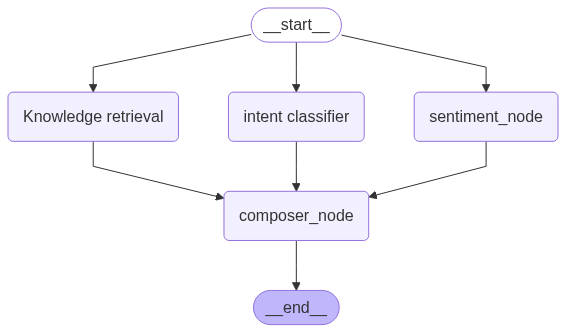

In [48]:

from IPython.display import Image, display

try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    raise(Exception)
